# Brain Tumor Detection
Description
This dataset was originally created by Yousef Ghanem. To see the current project, which may have been updated since this version, please go here: https://universe.roboflow.com/yousef-ghanem-jzj4y/brain-tumor-detection-fpf1f.

This dataset is part of RF100, an Intel-sponsored initiative to create a new object detection benchmark for model generalizability.

Access the RF100 Github repo: https://github.com/roboflow-ai/roboflow-100-benchmark

## Imports

In [104]:
from tqdm.notebook import tqdm
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()

import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
tf.config.list_physical_devices('GPU'), tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.18.0')

In [105]:
tf.random.set_seed(42)

In [106]:
from utils.visualization_funcs import plot_random_images_bbox
from utils.prepare_dataset import PrepareDataset

In [107]:
# auto reload dotenv 
%load_ext dotenv
%dotenv

# auto reload libs
%load_ext autoreload
%autoreload 2

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Paths Setup

In [108]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TRAIN_DIR)

datasets/brain-tumor-2/train/


In [109]:
cfg.DATASET_DIRS

{'TRAIN_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/train/', 'VALIDATION_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/valid', 'TEST_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/test'}

In [110]:
DATASET_DIRS = Path(cfg.DATASET.DATASET_DIR)
TRAIN_DIR = Path(cfg.DATASET_DIRS.TRAIN_DIR)
VALIDATION_DIR = Path(cfg.DATASET_DIRS.VALIDATION_DIR)
TEST_DIR = Path(cfg.DATASET_DIRS.TEST_DIR)

TRAIN_IMAGE_DIR = TRAIN_DIR / 'images'
TRAIN_LABELS_DIR = TRAIN_DIR / 'labels'

VALID_IMAGE_DIR = VALIDATION_DIR / 'images'
VALID_LABELS_DIR = VALIDATION_DIR / 'labels'

TEST_IMAGE = TEST_DIR / 'images'
TEST_LABELS = TEST_DIR / 'labels'

IMG_SIZE = cfg.TRAIN.IMG_SIZE
BATCH_SIZE = cfg.TRAIN.BATCH_SIZE

CLASS_NAME = [
    'label0',
    'label1',
    'label2'
]
class_map = {k: v for k, v in enumerate(CLASS_NAME)}

NUM_CLASSES = len(CLASS_NAME)

## Dataset Download from Roboflow

In [111]:
if not TRAIN_DIR.exists():
    from roboflow import Roboflow
    rf = Roboflow()
    project = rf.workspace("roboflow-100").project("brain-tumor-m2pbp")
    version = project.version(2)
    dataset = version.download("tensorflow")      

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to brain-tumor-2 in tensorflow:: 100%|██████████| 9908/9908 [00:00<00:00, 12343.33it/s]


## Load images from directory

In [9]:

prepare_train_dataset = PrepareDataset(image_dir=TRAIN_IMAGE_DIR, 
                                    label_dir=TRAIN_LABELS_DIR,
                                    dst_img_size=(IMG_SIZE, IMG_SIZE))

train_images, train_class_ids, train_bboxes  = prepare_train_dataset.get_dataset()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
len(train_images), len(train_class_ids), len(train_bboxes)

(2182, 2182, 2182)

Random samples: [1400, 712, 447, 67, 312, 1414, 414, 1692, 2080]


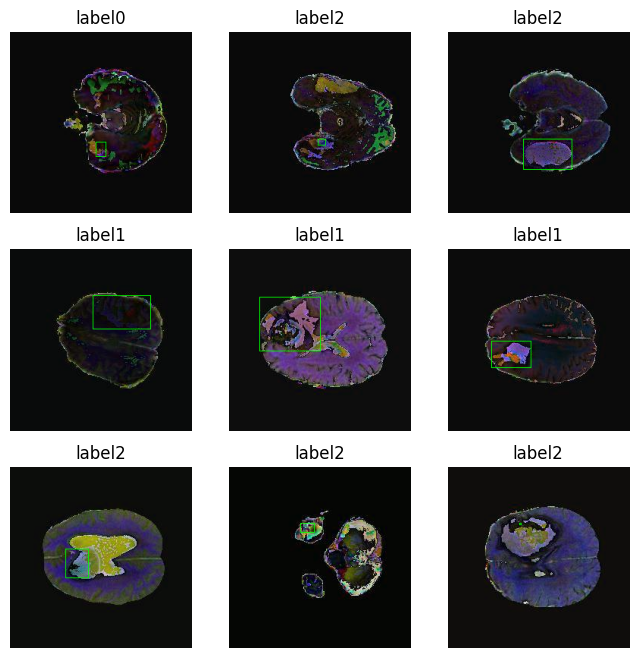

In [11]:
plot_random_images_bbox(image_paths=train_images, 
                        class_ids=train_class_ids, 
                        bboxes=train_bboxes,
                        class_map=class_map)

## Rebalance dataset by Down sempling to dataset with min images

In [12]:
# rebal_train_images, rebal_train_class_ids, rebal_train_bboxes = prepare_train_dataset.rebalance_by_down_sampling_datasets(augment=False)
# len(train_images), len(train_class_ids), len(train_bboxes)

In [13]:
# train_datasets = tf.data.Dataset.from_tensor_slices(
#     (rebal_train_images, rebal_train_class_ids, rebal_train_bboxes))
# del rebal_train_images, rebal_train_class_ids, rebal_train_bboxes
# len(train_datasets)
train_datasets = tf.data.Dataset.from_tensor_slices(
    (train_images, train_class_ids, train_bboxes))
del train_images, train_class_ids, train_bboxes
len(train_datasets)

I0000 00:00:1739687911.971785    4500 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7260 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:0a:00.0, compute capability: 8.6
2025-02-16 06:38:31.973446: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3016396800 exceeds 10% of free system memory.


2182

In [14]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def load_dataset(image, class_id, bbox):
    # images = load_image(image_path)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    
    # return   tf.cast(image, tf.float32), tf.cast(class_id, tf.int32), tf.cast(bbox, tf.float32) 
    return   image, (tf.one_hot(class_id,NUM_CLASSES), tf.cast(bbox, tf.float32))

def preprocess(image_batch, labels_batch):
    processed_image_batch = tf.keras.applications.densenet.preprocess_input(image_batch)
    return processed_image_batch, labels_batch

### Augmentation 

In [15]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1),
    layers.RandomSaturation(0.1),
    layers.RandomHue(0.1)
])

In [16]:
train_ds = train_datasets.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)

In [17]:
train_datasets.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=2182>

In [18]:
train_ds = train_ds.shuffle(buffer_size=train_datasets.cardinality(), reshuffle_each_iteration=True)\
                                .repeat() \
                                .batch(BATCH_SIZE, drop_remainder=True)\
                                .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)\
                                .prefetch(tf.data.AUTOTUNE)

In [19]:
for batch in train_ds.take(1):
    print(batch)

(<tf.Tensor: shape=(16, 224, 224, 3), dtype=float32, numpy=
array([[[[-1.7533247, -1.6629969, -1.4333837],
         [-1.7533247, -1.6629969, -1.4333837],
         [-1.7533247, -1.6629969, -1.4333837],
         ...,
         [-1.7533247, -1.6629969, -1.4333837],
         [-1.7533247, -1.6629969, -1.4333837],
         [-1.7533247, -1.6629969, -1.4333837]],

        [[-1.7533247, -1.6629969, -1.4333837],
         [-1.7533247, -1.6629969, -1.4333837],
         [-1.7533247, -1.6629969, -1.4333837],
         ...,
         [-1.7533247, -1.6629969, -1.4333837],
         [-1.7533247, -1.6629969, -1.4333837],
         [-1.7533247, -1.6629969, -1.4333837]],

        [[-1.7533247, -1.6629969, -1.4333837],
         [-1.7533247, -1.6629969, -1.4333837],
         [-1.7533247, -1.6629969, -1.4333837],
         ...,
         [-1.7533247, -1.6629969, -1.4333837],
         [-1.7533247, -1.6629969, -1.4333837],
         [-1.7533247, -1.6629969, -1.4333837]],

        ...,

        [[-1.7533247, -1.6629969

2025-02-16 06:40:31.835727: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Validation datasets setup

In [20]:
prepare_valid_datasets = PrepareDataset(image_dir=VALID_IMAGE_DIR,
                                label_dir=VALID_LABELS_DIR)
valid_image_paths, valid_class_ids, valid_bboxes = prepare_valid_datasets.get_dataset()
len(valid_image_paths), len(valid_class_ids), len(valid_bboxes)

  0%|          | 0/1000 [00:00<?, ?it/s]

(2244, 2244, 2244)

In [21]:
val_datasets = tf.data.Dataset.from_tensor_slices((valid_image_paths,
                                               valid_class_ids,
                                               valid_bboxes))

val_ds = val_datasets.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.repeat()\
                .batch(BATCH_SIZE, drop_remainder=True)\
                .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)\
                .prefetch(tf.data.AUTOTUNE)

2025-02-16 06:40:32.575768: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3102105600 exceeds 10% of free system memory.


In [22]:
for batch in val_ds.take(1):
    print(batch)

(<tf.Tensor: shape=(16, 224, 224, 3), dtype=float32, numpy=
array([[[[-1.8781574, -1.7731092, -1.5778649],
         [-1.8781574, -1.7731092, -1.5778649],
         [-1.8781574, -1.7731092, -1.5778649],
         ...,
         [-1.8781574, -1.7731092, -1.5778649],
         [-1.8781574, -1.7731092, -1.5778649],
         [-1.8781574, -1.7731092, -1.5778649]],

        [[-1.8781574, -1.7731092, -1.5778649],
         [-1.8781574, -1.7731092, -1.5778649],
         [-1.8781574, -1.7731092, -1.5778649],
         ...,
         [-1.8781574, -1.7731092, -1.5778649],
         [-1.8781574, -1.7731092, -1.5778649],
         [-1.8781574, -1.7731092, -1.5778649]],

        [[-1.8781574, -1.7731092, -1.5778649],
         [-1.8781574, -1.7731092, -1.5778649],
         [-1.8781574, -1.7731092, -1.5778649],
         ...,
         [-1.8781574, -1.7731092, -1.5778649],
         [-1.8781574, -1.7731092, -1.5778649],
         [-1.8781574, -1.7731092, -1.5778649]],

        ...,

        [[-1.8781574, -1.7731092

2025-02-16 06:42:32.647687: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Define DenseNet121 Model

In [23]:
import keras

### Define DenseNet121 as a Feature Extractor
def feature_extractor(inputs)-> tf.keras.Model:

    
    
    # Create a DenseNet121 model object
    densenet121 = tf.keras.applications.DenseNet121(
        include_top = False, 
        weights = "imagenet",
        input_shape = (IMG_SIZE, IMG_SIZE, 3),    
        input_tensor=inputs
    )
    densenet121.trainable = True
    for layer in densenet121.layers[:100]:
        layer.trainable = False

    # densenet121.trainable = False
    # for layer in densenet121.layers[:149]:
    #     layer.trainable = False
        
    # for layer in densenet121.layers[149:]:
    #     layer.trainable = True
        
    feature_extractor = densenet121.output
    return feature_extractor


### Define Dense Layers
def dense_layers(features)->tf.keras.Layer:
    # global average pooling 2d layer
    x = keras.layers.GlobalAveragePooling2D()(features)

    # flatten layer
    x = keras.layers.Flatten()(x)

    # 1024 Dense layer, with relu
    x = keras.layers.Dense(units=1024, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    # 512 Dense layer, with relu
    x = keras.layers.Dense(units=512, activation='relu')(x)

    # l2 = tf.keras.regularizers.l2

    # # x = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(features)
    # # x = tf.keras.layers.BatchNormalization()(x)
    # # x = tf.keras.layers.MaxPool2D((2,2))(x)
    
    # x = tf.keras.layers.GlobalAveragePooling2D()(features)
    # x = tf.keras.layers.Flatten()(x)
    # # x = tf.keras.layers.Dropout(0.2)(x)

    # x = tf.keras.layers.Dense(units=1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    # # x = tf.keras.layers.Dropout(0.2)(x)
    # x = tf.keras.layers.Dense(units=512, activation='relu',  kernel_regularizer=l2(0.01))(x)

    return x

### Define Bounding Box Regression
def bounding_box_regression(x)->tf.keras.Layer:

    # Dense layer named `bounding_box`
    bounding_box_regression_output = tf.keras.layers.Dense(units=4, name='bounding_box')(x)

    return bounding_box_regression_output

###Define Classifier Layer
def classifer(inputs)->tf.keras.Model:
    return tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax', name = 'classification')(inputs)

### Final Model

In [24]:
def mobv2_feature_extractor(inputs):
    
    inputs = tf.keras.applications.mobilenet.preprocess_input(inputs)

    # Create a mobilenet version 2 model object
    mobilenet_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    )

    # pass the inputs into this modle object to get a feature extractor for these inputs
    feature_extractor = mobilenet_model(inputs)

    # return the feature_extractor
    return feature_extractor#.outputs

In [25]:
def final_model()->tf.keras.Model:
    
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    _feature_extractor = feature_extractor(inputs)
    # _feature_extractor = mobv2_feature_extractor(inputs)
    
    dense_output = dense_layers(_feature_extractor)

    bounding_box_regression_output = bounding_box_regression(dense_output)

    classification_output = classifer(dense_output)

    return tf.keras.Model(inputs=inputs, 
                          outputs=[classification_output, 
                                   bounding_box_regression_output])

In [57]:
import math
# Get the length of the training set
length_of_training_dataset = len(train_datasets)

# Get the length of the validation set
length_of_validation_dataset = len(val_datasets)

# Get the steps per epoch 
steps_per_epoch = math.ceil(length_of_training_dataset/BATCH_SIZE)

# get the validation steps (per epoch) 
validation_steps = math.ceil(length_of_validation_dataset/BATCH_SIZE)
validation_steps

141

### Learning Rate Tuning


In [ ]:
# init_learning_rate = 1e-8
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: init_learning_rate * 10**(epoch / 20))

# # Initialize the optimizer
# model_tune = final_model()
# model_tune.compile(
#     optimizer=tf.keras.optimizers.SGD(learning_rate=init_learning_rate, momentum=0.9),
#     loss={'classification': 'categorical_crossentropy', 'bounding_box': 'mse'},
#     metrics={'classification': 'accuracy', 'bounding_box': 'mse'})

# # Train the model
# history = model_tune.fit(train_ds, epochs=150,     
#                          steps_per_epoch=steps_per_epoch,
#                         callbacks=[lr_schedule])

Epoch 1/150
137/137 ━━━━━━━━━━━━━━━━━━━━ 54s 42ms/step - bounding_box_loss: 1.1187 - bounding_box_mse: 1.1187 - classification_accuracy: 0.4127 - classification_loss: 1.1746 - loss: 2.2933 - learning_rate: 1.0000e-08
Epoch 2/150
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - bounding_box_loss: 1.0989 - bounding_box_mse: 1.0989 - classification_accuracy: 0.4279 - classification_loss: 1.1651 - loss: 2.2639 - learning_rate: 1.1220e-08
Epoch 3/150
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - bounding_box_loss: 1.1038 - bounding_box_mse: 1.1038 - classification_accuracy: 0.4076 - classification_loss: 1.1983 - loss: 2.3021 - learning_rate: 1.2589e-08
Epoch 4/150
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - bounding_box_loss: 1.1008 - bounding_box_mse: 1.1008 - classification_accuracy: 0.4235 - classification_loss: 1.1688 - loss: 2.2696 - learning_rate: 1.4125e-08
Epoch 5/150
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - bounding_box_loss: 1.1145 - bounding_box_mse: 1.1145 - classification_accuracy:

(np.float64(1e-08), np.float64(0.1), np.float64(0.0), np.float64(5.0))

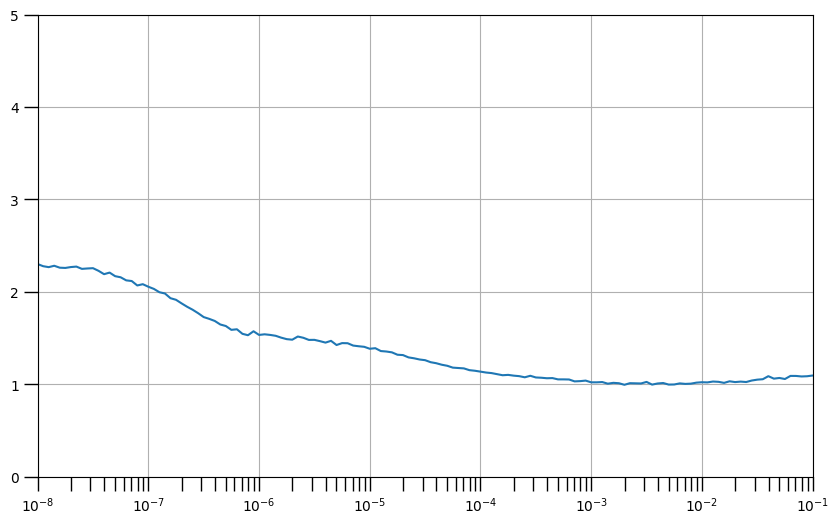

In [ ]:
# Define the learning rate array
# lrs = init_learning_rate * (10 ** (np.arange(150) / 20))

# # Set the figure size
# plt.figure(figsize=(10, 6))

# # Set the grid
# plt.grid(True)

# # Plot the loss in log scale
# plt.semilogx(lrs, history.history["loss"])

# # Increase the tickmarks size
# plt.tick_params('both', length=10, width=1, which='both')

# # Set the plot boundaries
# plt.axis([1e-8, 1e-1, 0,5])

### Define  Callbacks

In [90]:
LEARNING_RATE = 8e-2
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=5,
                                                  min_delta=0.00001,
                                                  verbose=1,
                                                  restore_best_weights=True)

# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
#                                                  factor=0.1, 
#                                                  patience=3, 
#                                                  verbose=1, 
#                                                  mode='auto', 
#                                                  min_delta=0.00005, 
#                                                  cooldown=0, 
#                                                  min_lr=0.0001)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(        
        initial_learning_rate=LEARNING_RATE,
        decay_steps=100_000,
        decay_rate=0.9,
        staircase=True)


model_checkpoint =  tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}.weights.h5',
        save_weights_only=True),

### Define Optimizer

In [91]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, use_ema=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9, clipvalue=1.0)

# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, clipvalue=1.0)

## Model Building and Compilation

In [92]:
tf.keras.backend.clear_session()

In [93]:
densenet121_model = final_model()

In [94]:
densenet121_model.compile(
    optimizer=optimizer,
    loss={'classification': 'categorical_crossentropy', 'bounding_box': 'mse'},
    metrics={'classification': 'accuracy', 'bounding_box': 'mse'})

In [95]:
# densenet121_model.summary()

### Train and Validate the model

In [96]:
EPOCHS = 50

In [97]:
history = densenet121_model.fit(
    train_ds,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=validation_steps,
    callbacks=[model_checkpoint],
    # callbacks=[reduce_lr, early_stopping, model_checkpoint],
)

Epoch 1/50


137/137 ━━━━━━━━━━━━━━━━━━━━ 62s 109ms/step - bounding_box_loss: 118969.1016 - bounding_box_mse: 118969.1016 - classification_accuracy: 0.3712 - classification_loss: 42.7076 - loss: 119011.8047 - val_bounding_box_loss: 0.0136 - val_bounding_box_mse: 0.0136 - val_classification_accuracy: 0.4428 - val_classification_loss: 1.0742 - val_loss: 1.0878
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - bounding_box_loss: 0.0335 - bounding_box_mse: 0.0335 - classification_accuracy: 0.4600 - classification_loss: 1.0783 - loss: 1.1118 - val_bounding_box_loss: 0.0120 - val_bounding_box_mse: 0.0120 - val_classification_accuracy: 0.4428 - val_classification_loss: 1.0830 - val_loss: 1.0950
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - bounding_box_loss: 0.1150 - bounding_box_mse: 0.1150 - classification_accuracy: 0.4473 - classification_loss: 1.0991 - loss: 1.2141 - val_bounding_box_loss: 0.0117 - val_bounding_box_mse: 0.0117 - val_classification_accuracy: 0.4428 - val_classification_lo

## Model Evaluation

### Testing Datasets setup

In [98]:
# TEST_IMAGE = TEST_DIR/'images'
# TEST_LABELS = TEST_DIR/'labels'

# prepare_test_datasets = PrepareDataset(image_dir=TEST_IMAGE,
#                                 label_dir=TEST_LABELS)
# test_image_paths, test_class_ids, test_bboxes = prepare_test_datasets.get_dataset()
# len(test_image_paths), len(test_class_ids), len(test_bboxes)

In [99]:
# test_datasets = tf.data.Dataset.from_tensor_slices((test_image_paths,
#                                                test_class_ids,
#                                                test_bboxes))

# test_ds = test_datasets.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
# test_ds = test_ds.repeat()\
#                 .batch(BATCH_SIZE, drop_remainder=True)\
#                  . map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)\
#                 .prefetch(tf.data.AUTOTUNE)

In [100]:
# loss, classification_loss, bounding_box_loss, classification_accuracy, bounding_box_mse = densenet121_model.evaluate(test_ds, steps=1)
# print("Testing accuracy: ", classification_accuracy)

In [101]:
def plot_metrics(metric_name, title, ylim=1):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.xlabel("Epochs")
  plt.legend([metric_name, 'val_' + metric_name])
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

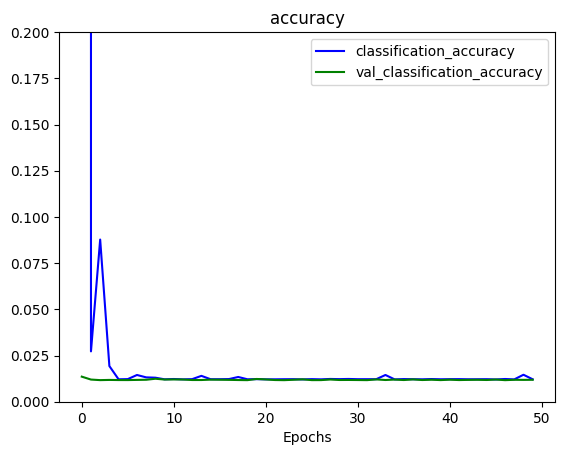

In [102]:
plot_metrics("bounding_box_loss", "bounding_box_loss", ylim=0.2)
plot_metrics("classification_accuracy", "accuracy", ylim=0.2)

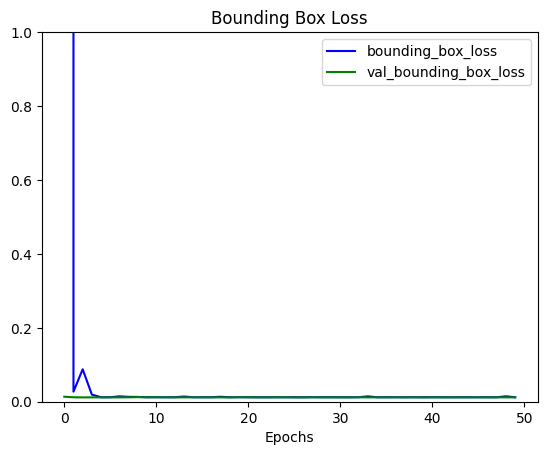

In [103]:
plot_metrics("classification_loss", "Classification Loss")
plot_metrics("bounding_box_loss", "Bounding Box Loss")